First we import the required python libraries for this notebook. 

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import random

In order to begin our analysis, we need to obtain the EMNIST data contained in the matlab.zip file found at <a href="https://www.nist.gov/itl/iad/image-group/emnist-dataset"> nist.gov </a>. We unzip this file so that the emnist-digits.mat file is present in the working directory.

We use scipy to load the EMNIST data. 

In [2]:
emnist_digits = scipy.io.loadmat('emnist-digits.mat')

From our loaded data, we extract the relevant data. The list `digit_images` will contain 240,000 elements corresponding to 240,000 images of handwritten digits data. Each of the elements in `digit_images` is itself a list of length 784 that contains the data of the 784 pixels that comprise each digit image.

The list `digit_labels` will be a list of length 240,000 that is the actual number represent by the corresponding image in `digit_images`.

In [3]:
digit_images = emnist_digits['dataset'][0][0][0][0][0][0]
digit_labels = [x[0] for x in emnist_digits['dataset'][0][0][0][0][0][1]]

In a similar fashion, we create the lists `test_digit_images` and `test_digit_labels` that correspond to the 40,000 digits in our test data. 

In [4]:
test_digit_images = emnist_digits['dataset'][0][0][1][0][0][0]
test_digit_labels = [x[0] for x in emnist_digits['dataset'][0][0][1][0][0][1]]

Each pixel in `digit_images` and `test_digit_images` is a gray-scale number from 0 to 255. It is easiest if we scale this data so that each pixel is between 0 and 1. To do this, we divide each of the elements in `digit_images` and `test_images` by 255. 

In [5]:
digit_images = np.asarray(digit_images, dtype=np.float32)/255
test_digit_images = np.asarray(test_digit_images, dtype=np.float32)/255

We want to see if we loaded the data correctly. To do this we have a look at the 1000th digit.

In [7]:
identification = 999
actual_number = test_digit_labels[identification]
 
print("The digit with index %s in our test data should be a %s." %(identification, actual_number))

The digit with index 999 in our test data should be a 7.


We need reshape this image data so that instead of it being a list of length 784, it is as 28 x 28 array. We use NumPy's `reshape` to create this array. We need to use `order='F'` in order for the data to be displayed in the correct orientation. 

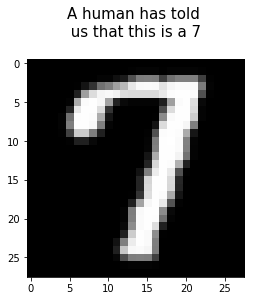

In [8]:
data = test_digit_images[identification]
image_data = data.reshape(28, 28, order='F')

plt.gray()
plt.imshow(image_data, interpolation='none')
plt.title('A human has told \n us that this is a %s \n' %actual_number, fontsize=15)
plt.show()

Having loaded the EMNIST data, we are in a position to create a neural network to analyse it.

To do this we create a `NeuralNetwork` class. Each neural network will be initialised with the list `layers`. This list will contain the number of neurons in each layer. For example, the object:

`a = NeuralNetwork(layers = [4,3,2])` 

will contain 4 neurons in the 0th layer, 3 neurons in the 1st layer and 2 neurons in the 2nd layer. 

Each `NeuralNetwork` instance will also need to be intialised with `weights`, `biases`, `activations` and `deltas`. 

Both the `activations` and `deltas` will be lists with the same length as the number of layers. Each element in these lists will be initialised to an appropriate zero column vector. For example, a neural network initialised with `layers = [4,3,2]` could have:

$ \mbox{activations} = \left( \underbrace{\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0\end{bmatrix}, \begin{bmatrix} 0 \\ 0\\ 0\end{bmatrix}, \begin{bmatrix} 0 \\ 0 \end{bmatrix}}_{\mbox{number of layers}} \right)$




The `biases` will be initialised with random normally distrubted values. For example, a neural network initialised with `layers = [4,3,2]` could have:


$ \mbox{biases} = \left( \underbrace{\begin{bmatrix} -0.23517805 \\ -0.0274411 \\ 0.86693116 \\ 1.63671622\end{bmatrix}, \begin{bmatrix} -2.19653105 \\ 1.41777237\\ 0.49982226\end{bmatrix}, \begin{bmatrix} -0.82112515 \\ 0.65460335 \end{bmatrix}}_{\mbox{number of layers}} \right)$

We use the notation from <a href='http://neuralnetworksanddeeplearning.com/chap2.html'>Neural Networks and Deep Learning</a> so that $w^l_{jk}$ represent the weight of the $k$th neuron in the $(l-1)$th layer to the $j$th neuron in the $l$th layer. 

Our `weights` will be a list. For example, a neural network initialised with `layers = [4,3,2]` could have:

$ \mbox{weights} = \left( \underbrace{[], \scriptsize \begin{bmatrix} 1.68409525 & 0.23314265 & 1.32528275 & -0.46492337 \\ 0.79449842 & 0.74707181 & 0.50216752 & 1.07123871 \\ 1.70751973 & 0.92005992 & 0.74187835 & 1.44667628 \end{bmatrix}, \begin{bmatrix}-1.96203677 & 0.78321492 & 0.18024262 \\  0.74463795 & 1.40177271 & -1.10609429 \end{bmatrix}}_{\mbox{number of layers}} \right)$

Note that the 0th element of the `weights` list is always `[]`.


In [9]:
class NeuralNetwork:
    
    def __init__(self, layers):
        
        self.layers = layers
                
        self.weights = [[]] + [np.random.randn(layers[x], layers[x-1]) for x in range(1,len(layers))] 
        self.biases = [np.random.randn(x, 1) for x in layers]
        self.activations = [np.zeros((x, 1)) for x in layers]
        
        self.deltas = [np.zeros((x, 1)) for x in layers]

We define both the `sigmoid` and `sigmoid_derivative` functions that will be essential later.  

In [10]:
def sigmoid(z):
    
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    
    return sigmoid(z)*(1-sigmoid(z))



We define a `feed_forward` class method to our `NeuralNetwork` class. The `feed_forward` class method will take an `input` list that represents the initial activations of the 0th layer.

The activations of the other layers are calculated as $a^l = \sigma (w^l a^{l-1} + b^l)$ for $l=1,2,3...,L$

In [11]:
def feed_forward(self, input):
    
    # Check to see if the number of elements in the input is the same as the number
    # of neurons in the first layer.
    if len(input) != len(self.activations[0]):
        raise ValueError('The number of elements in the input is not the same as the number of neurons in the 0th layer!') 
        
    self.activations[0] = np.asarray([input]).T 
        
    self.weighted_outputs = [[]]
                      
    for x in range(1, len(self.layers)):
            
        z = np.dot(self.weights[x], self.activations[x-1]) + self.biases[x]
        self.weighted_outputs.append(z)
            
        self.activations[x] = sigmoid(z)                      
                       
    return

# Add the feed_forward function to the NeuralNetwork class.
NeuralNetwork.feed_forward = feed_forward

We create the function `digit_to_desired_output` that turns a digit into an array of what the activations of the last layer should be. For example:

`digit_to_desired_output(2)`$ = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0  \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}$

In [12]:
def digit_to_desired_output(digit):
    
    desired_output = np.zeros((10,1))
    desired_output[digit] = [1]
    
    return desired_output

We add a `back_propagate` class method to our `NeuralNetwork` class. The `back_propagate` function takes an array:

`desired_output`$ =y$ and first determines the error, $\delta^L$, in the last layer according to:

$\delta^L = (a^L - y) \odot \sigma'(z^L)$

It then backpropagates this error according to the equation:

$ \delta^l = \left( {\left( w^{l+1} \right)}^T \delta^{l+1} \right) \odot \sigma'(z^l) $

for $l=L-1, L-2, ..., 1$



In [13]:
def back_propagate(self, desired_output):
        
    self.deltas[-1] = (self.activations[-1] - desired_output) * sigmoid_derivative(self.weighted_outputs[-1])
        
    for x in range(1, len(self.layers)-1)[::-1]:
            
        self.deltas[x] = np.dot(self.weights[x+1].T, self.deltas[x+1]) * sigmoid_derivative(self.weighted_outputs[x])

# Add the back_propagate function to the NeuralNetwork class.
NeuralNetwork.back_propagate = back_propagate
        

We next need to create and `update_network` class method for our `NeuralNetwork` class that updates the `biases` and `weights`. 

The `biases` and `weights` will be updated using a gradient descent method with a mini-batch size of one. The weights will be updated according to the rule:

$w^l \rightarrow w^l - \eta \cdot \delta^l {\left(a^{l-1} \right)}^T$

The biases will be updated according to the rule:

$b^l \rightarrow b^l - \eta \cdot \delta^l$

In both the equations above, $\eta$ is a small positive parameter called the learning rate.

In [14]:
def update_network(self, eta):
        
    for x in range(1, len(self.layers))[::-1]:
        
        self.biases[x] = self.biases[x] - eta*self.deltas[x]
        self.weights[x] = self.weights[x] - eta*self.deltas[x]*(self.activations[x-1].T) 
        
    return

# Add the back_propagate function to the NeuralNetwork class.
NeuralNetwork.update_network = update_network

We are in a position now to begin training our neural network.

As in <a href='http://neuralnetworksanddeeplearning.com/chap2.html'>Neural Networks and Deep Learning</a> we define a neural network with the 0th layer having 784 neurons representing the 784 individual pixels. We have a 1st layer of 30 neurons. Since there are ten digits, our 2nd and last layer will have 10 neurons in it.

In [15]:
network = NeuralNetwork([784,30,10])

We create a function `shuffle_order` that shuffles the order of the training data:

In [32]:
def shuffle_order(digit_images, digit_labels):
    
    randomise_data = list(zip(digit_images, digit_labels))
    random.shuffle(randomise_data)
    digit_images, digit_labels = zip(*randomise_data) 
    
    return digit_images, digit_labels

We will create a function called `test` that tests the neural network that we will train. 

In [17]:
def test(network, test_digit_images, test_digit_labels):

    number_of_checks = 0
    number_of_successes = 0

    for i in range(len(test_digit_images)):
        input = test_digit_images[i]
        network.feed_forward(input)
    
        desired_output = digit_to_desired_output(test_digit_labels[i])        
       
        if np.argmax(network.activations[-1]) == test_digit_labels[i]:
            number_of_successes = number_of_successes + 1
        
        number_of_checks = number_of_checks + 1
      
    success_rate = (float(number_of_successes) / number_of_checks)*100

    return success_rate

We will train our neural network over 30 epochs with a eta value of 0.1. 

In [33]:
eta = 0.1
epochs = 1
test_data = False 


for i in range(epochs):
    
    print("Starting Epoch %s" %i)
    
    digit_images, digit_labels = shuffle_order(digit_images, digit_labels) 
    
    for j in range(len(digit_images)):
        
        input = digit_images[j]
        network.feed_forward(input)
    
        desired_output = digit_to_desired_output(digit_labels[j])
    
        network.back_propagate(desired_output)
    
        
        network.update_network(eta)
        
    if test_data:
        
        success_rate = test(network, test_digit_images, test_digit_labels) 
        print("Success rate was %s percent" %success_rate)

Starting Epoch 0


As an interesting conclusion, we look to see if our neural network can correctly predict the 1000th test data digit. 

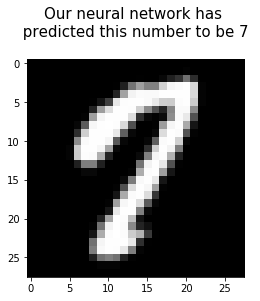

In [34]:
identification = 2


input = test_digit_images[identification]
network.feed_forward(input)
prediction = np.argmax(network.activations[-1])

image_data = input.reshape(28, 28, order='F')

plt.gray()
plt.imshow(image_data, interpolation='none')
plt.title('Our neural network has \n predicted this number to be %s \n' %prediction, fontsize=15)
plt.show()


As we can see, the neural network that we created has correctly predicted this number to be 7.

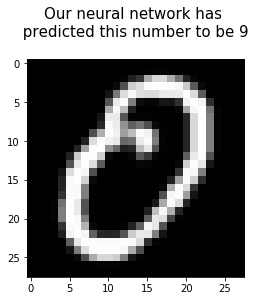

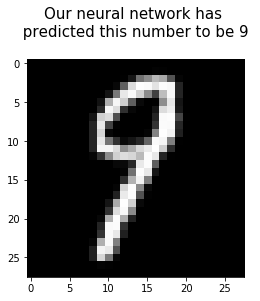

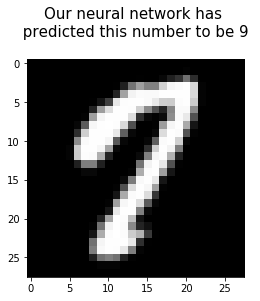

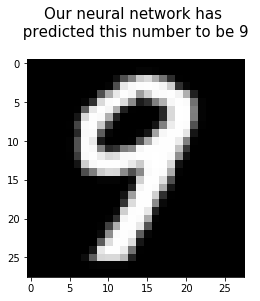

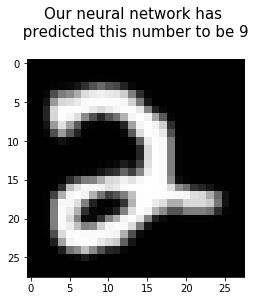

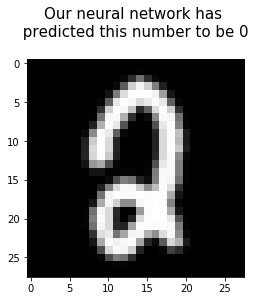

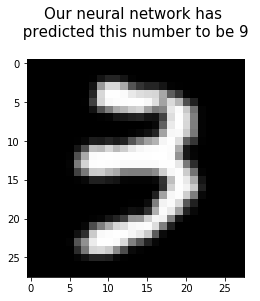

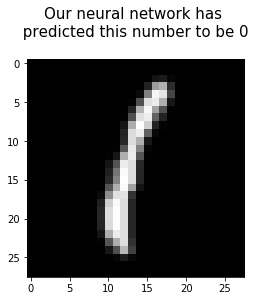

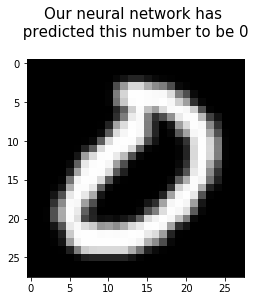

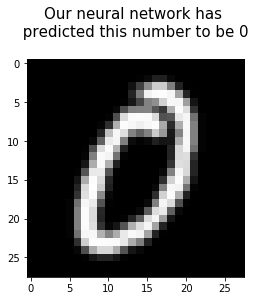

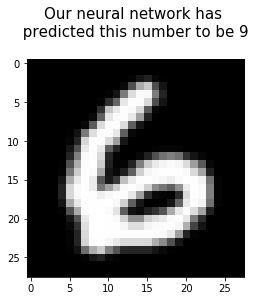

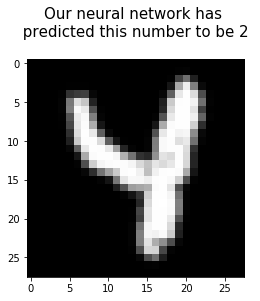

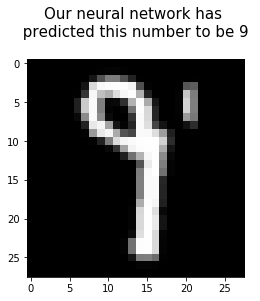

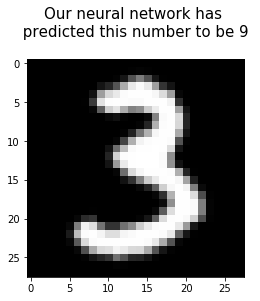

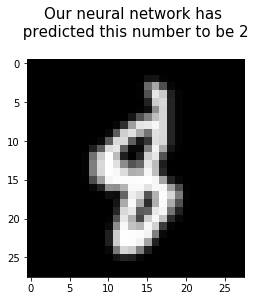

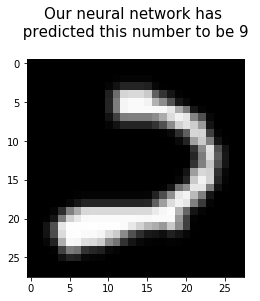

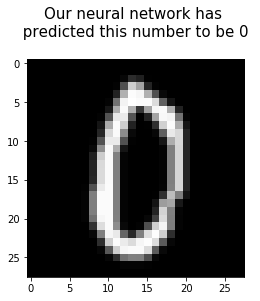

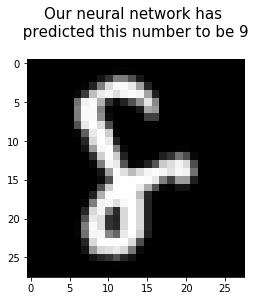

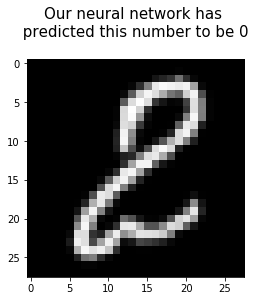

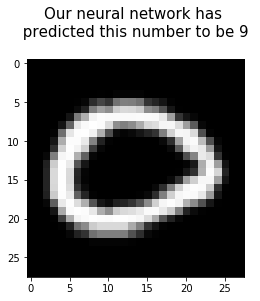

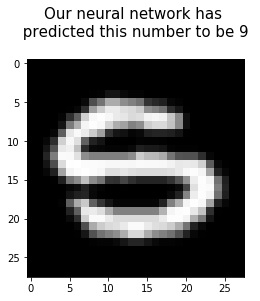

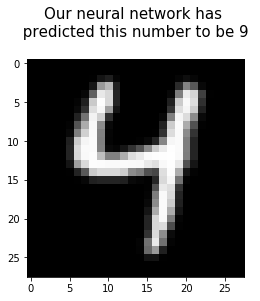

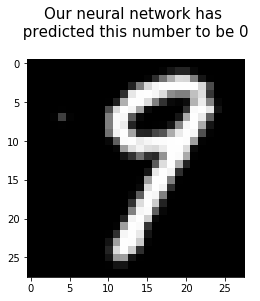

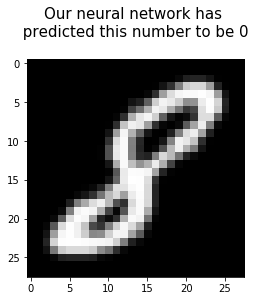

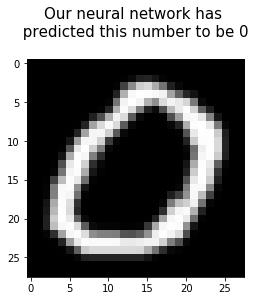

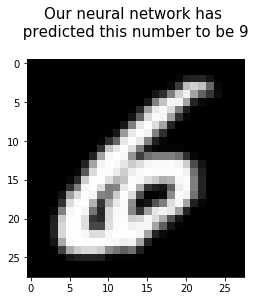

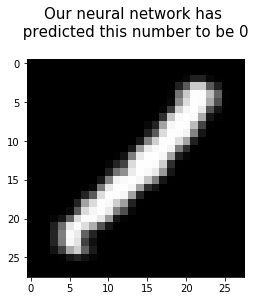

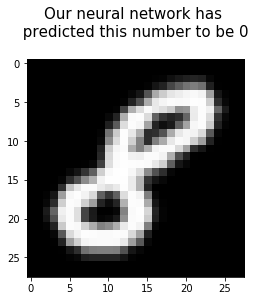

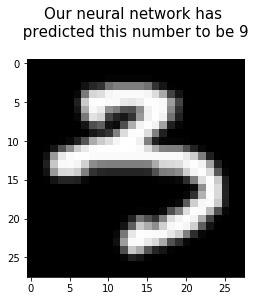

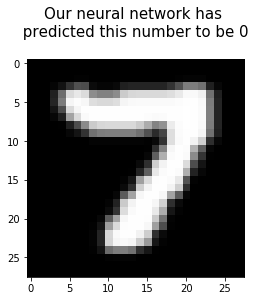

In [22]:
for identification in range(30):

    input = test_digit_images[identification]
    network.feed_forward(input)
    prediction = np.argmax(network.activations[-1])

    image_data = input.reshape(28, 28, order='F')

    plt.gray()
    plt.imshow(image_data, interpolation='none')
    plt.title('Our neural network has \n predicted this number to be %s \n' %prediction, fontsize=15)
    plt.show()


In [ ]:
Should only appear on branch validation.